In [1]:
from qiskit import QuantumCircuit
from qiskit_ibm_provider import IBMProvider
import numpy as np

# Analysing IBM's 7 qubit backend

In [2]:
provider = IBMProvider()
backend = provider.get_backend("ibmq_jakarta")

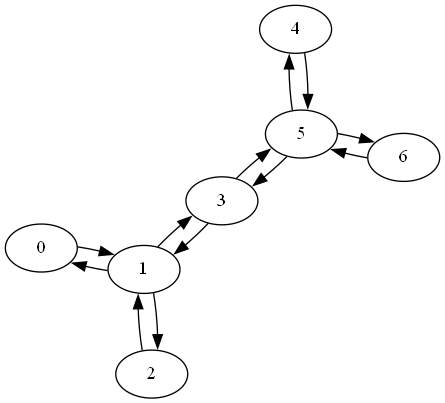

In [3]:
backend.coupling_map.draw()

In [4]:
backend.operations

[Instruction(name='id', num_qubits=1, num_clbits=0, params=[]),
 Instruction(name='rz', num_qubits=1, num_clbits=0, params=[Parameter(λ)]),
 Instruction(name='sx', num_qubits=1, num_clbits=0, params=[]),
 Instruction(name='x', num_qubits=1, num_clbits=0, params=[]),
 Instruction(name='cx', num_qubits=2, num_clbits=0, params=[]),
 Instruction(name='reset', num_qubits=1, num_clbits=0, params=[]),
 Instruction(name='measure', num_qubits=1, num_clbits=1, params=[]),
 Delay(duration=t[unit=dt]),
 qiskit.circuit.controlflow.if_else.IfElseOp]

In [5]:
print(backend.properties().gate_length('id', 3))
print(backend.properties().gate_length('rz', 3))
print(backend.properties().gate_length('sx', 3))
print(backend.properties().gate_length('x', 3))

3.5555555555555554e-08
0.0
3.5555555555555554e-08
3.5555555555555554e-08


In [6]:
print(0.00001/(backend.properties().gate_length('id', 2)))
print(0.00001/(backend.properties().gate_length('cx', (3,5))))

281.25000000000006
34.29878048780488


In [7]:
del backend

# Generate random 2 qubits circuit with n single qubit operations and k CNOTs

We will use qubits 3, 5 for the circuit and try to detect the CNOT with 1, 4, 6.
For now we only do CNOTs with 3 as the control.

We can see from the fidelety usually plumets after 20 CNOTs.

In [8]:
max_cnots = 20
random_circs_per_cnot_value = 60
prob_of_cnot = 1/4

num_of_qubits = 7
q1 = 3
q2 = 5
snoopers = (1,4,6)

In [9]:
def init_snoopers(num_of_qubits, snoopers):
    qc = QuantumCircuit(num_of_qubits)
    qc.h(snoopers)
    qc.barrier()
    return qc

def readout_snoopers(num_of_qubits, snoopers):
    qc = QuantumCircuit(num_of_qubits, len(snoopers))
    qc.barrier()
    qc.h(snoopers)
    for s_i, s in enumerate(snoopers):
        qc.measure(s, s_i)
    return qc

In [10]:
def random_2_qubit_init(num_of_qubits, q1, q2):
    qc = QuantumCircuit(num_of_qubits)
    for q in (q1, q2):
        qc.rz(np.random.random()*(2*np.pi), q)
        if np.random.randint(2) < 1:
            qc.sx(q)
        if np.random.randint(2) < 1:
            qc.x(q)
    qc.barrier()
    return qc

In [11]:
def random_2_qubit_circuit(num_of_qubits, q1, q2, no_of_cnots, prob_of_cnot) -> QuantumCircuit:
    '''
        num_of_qubits: number of qubits in the backend
        q1: qubit 1,
        q2: qubit 2
        no_of_cnots: # of CNOTs
        prob_of_cnot: probability of CNOT
    '''
    cnot_depth = 0
    other_depth = 0
    qc = random_2_qubit_init(num_of_qubits, q1, q2)
    while cnot_depth < no_of_cnots:
        p = np.random.random()
        if p > prob_of_cnot:
            for q in (q1, q2):
                op_type = np.random.randint(0, 4)
                match op_type:
                    case 0:
                        qc.rz(np.random.random()*(2*np.pi), q)
                    case 1:
                        qc.sx(q)
                    case 2:
                        qc.x(q)
                    case 3:
                        qc.id(q)
            other_depth += 1
        else:
            qc.cx(q1, q2)
            cnot_depth += 1
    return qc


In [12]:
qc1 = init_snoopers(num_of_qubits, snoopers)
qc2 = readout_snoopers(num_of_qubits, snoopers)

qcs: list[QuantumCircuit] = []
for k in range(max_cnots):
    for i in range(random_circs_per_cnot_value):
        victim_qc = random_2_qubit_circuit(num_of_qubits, q1, q2, k, prob_of_cnot)
        qc = qc1.compose(victim_qc).compose(qc2)
        qcs.append(qc)

# Save qcs

In [13]:
import pickle

with open('snooping_qcs_{}_qubits_IBMQ.pickle'.format(num_of_qubits), 'wb') as file:
    pickle.dump((max_cnots, random_circs_per_cnot_value, q1, q2, snoopers, qcs), file)